# Sinusoid reconstruction with Deep Preconditioners

## Author: M.Ravasi

This first notebook introduces the concept of Deep Preconditioners with the help of a toy example.

More specifically, we are interested to reconstruct a 1D sinuisodal signal given access to a small number of irregularly sampled values. The problem is casted as follows:

- given knowledge of the underlying statistics of the signal, multiple realizations are created and used to train an AutoEncoder;
- the trained Decoder is used as a nonlinear preconditioner to the solution of the reconstruction problem.

To conclude, this methodology is compared to two classical approaches in the field of inverse problems: a) spatially regularized inversion, b) PCA-assisted inversion.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pylops

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pytorch_lightning import seed_everything
from pylops_gpu import TorchOperator
from pylops_gpu import Restriction as gRestriction
from torchsummary import summary

from deepprecs.utils import set_seed

from dataset import *
from model import *
from train_pl import *

plt.style.use('default')  # seaborn-whitegrid, ggplot, bmh

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

"""
plt.rc('text', usetex=True)
"""
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title
plt.rc('font', serif='Times New Roman') 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
################# GLOBAL ####################
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Seed
seed_everything(5)

################# DATA ######################
# Number of realization
nreals = 40000

# Time and frequency axis
nt = 500
nfft = 2**11
dt = 0.004

# Sinusoids parametrization
f0 = [5, 3, 8]
sigmaf = [0.5, 1., 0.6]
a0 = [20., 10., 6.]
sigmaa = [0.1, 0.5, 0.6]
phi0 = [0., 0., 0.]
sigmaphi = [10.0, 20.0, 30.0]


################# NETWORK ###################
# Size of latent space
nenc = 35

# Number of epochs
num_epochs = 15

# Batch size
batch_size = 128

# Noise injection
add_noise = True
noise_std = 0.3

################# INVERSION #################
# Percentage of available samples in 1D signal
perc_subsampling=0.2

# Regularization parameters
epsR = np.sqrt(0.5)
epsI = np.sqrt(1e-4)

# Number of iterations
maxiter = 30

INFO: Global seed set to 5


cuda:0


## Data generation

To begin with let's generate a large set of sinusoidal signals all consistent with the same statistical process.

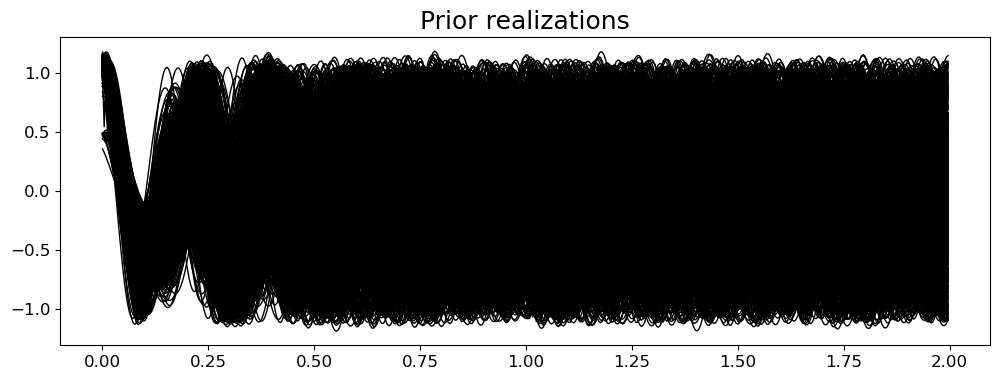

In [3]:
# Time and frequency axis
t = np.arange(nt)*dt
f = np.fft.rfftfreq(nfft, dt)

# Generate ensemble of sinusoids
xs = np.array([prior_realization(f0, a0, phi0, sigmaf, sigmaa, sigmaphi, dt, nt, nfft) \
               for _ in range(nreals)])

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(t, xs[:1000].T, 'k', lw=1)
ax.set_title('Prior realizations');

## Reconstruction problem

Before we start our training process, let's define the restriction operator to be used in the subsequent reconstruction process. 

We will provide our network with such an operator so that later we can apply it directly to the output of its decoder

In [4]:
# Restriction operator 
nsub = int(np.round(nt*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nt))[:nsub])

R1op = pylops.Restriction(nt, iava, dtype='float64') # CPU
Rop = gRestriction(nt, iava, dtype=torch.float32, device=device) # GPU
Rop_torch = TorchOperator(Rop, pylops=False) # Embed into a Torch operator

## Network creation

Let's now create the AutoEnconder network and train it on the data that we have just created

In [5]:
autoencoder = Autoencoder(nt, nenc=nenc, restriction=Rop_torch)
autoencoder = autoencoder.cuda(0)
print(autoencoder)

Autoencoder(
  (encode): Sequential(
    (0): Linear(in_features=500, out_features=70, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=70, out_features=35, bias=True)
    (3): Tanh()
  )
  (decode): Sequential(
    (0): Linear(in_features=35, out_features=70, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=70, out_features=500, bias=True)
  )
)


In [6]:
summary(autoencoder, input_size=(1, nt))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 70]          35,070
              ReLU-2                [-1, 1, 70]               0
            Linear-3                [-1, 1, 35]           2,485
              Tanh-4                [-1, 1, 35]               0
            Linear-5                [-1, 1, 70]           2,520
              ReLU-6                [-1, 1, 70]               0
            Linear-7               [-1, 1, 500]          35,500
Total params: 75,575
Trainable params: 75,575
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.29
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


## Train

We are now ready to train the Autoencoder. Let's first split our dataset into training and validation sets

In [7]:
# Define training dataset
x_train, x_valid, _, _ = train_test_split(xs, xs, test_size=0.33, random_state=42)

datamodule = DataModule(x_train, x_valid, batch_size=batch_size)

In [8]:
# Training
criterion = nn.MSELoss()
dimred = LitAutoencoder(autoencoder, criterion, noise_std=noise_std)
callback = MetricsCallback()

trainer = pl.Trainer(accelerator='gpu', devices=[0, ], 
                     max_epochs=num_epochs, log_every_n_steps=10, callbacks=[callback, ])
trainer.fit(dimred, datamodule)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type        | Params
------------------------------------------
0 | network   | Autoencoder | 75.6 K
1 | criterion | MSELoss     | 0     
------------------------------------------
75.6 K    Trainable params
0         Non-trainable params
75.6 K    Total params
0.302     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


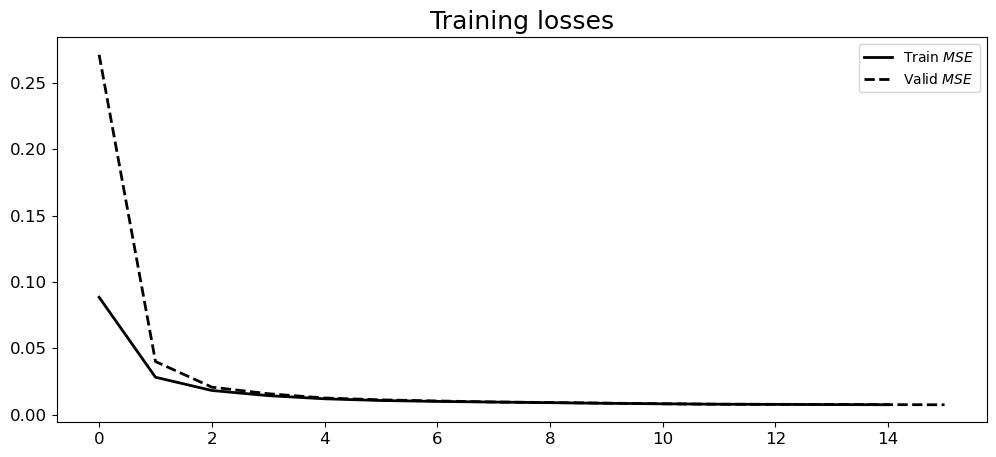

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(callback.train_loss, 'k', lw=2, label=r'Train $MSE$')
plt.plot(callback.valid_loss, '--k', lw=2, label=r'Valid $MSE$')
plt.title('Training losses')
plt.legend();

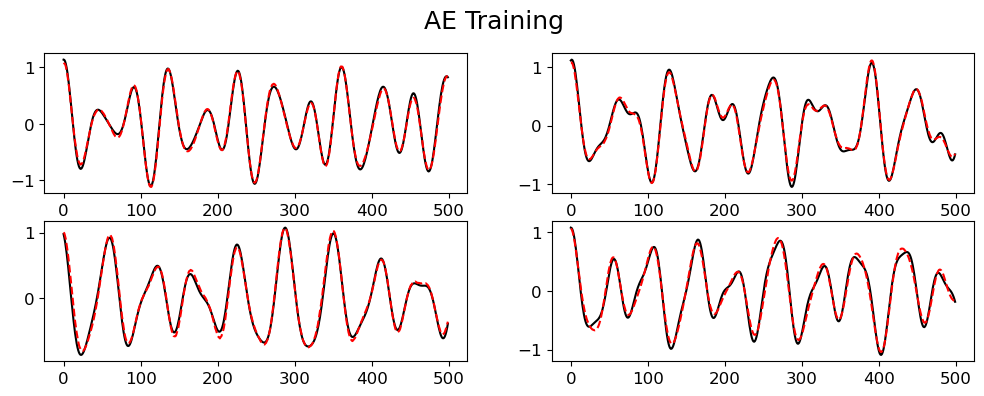

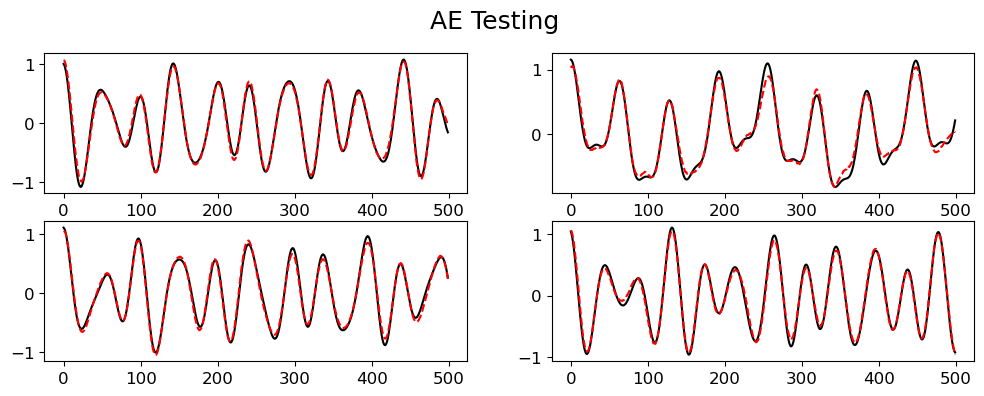

In [10]:
# Predict with AE
x_train1 = torch.from_numpy(x_train.astype(np.float32)).to(device)
x_valid1 = torch.from_numpy(x_valid.astype(np.float32)).to(device)

autoencoder.cuda(0)
x_train_ae, _ = autoencoder(x_train1)
x_valid_ae, _ = autoencoder(x_valid1)

# Visualization
n = 4
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs = axs.flatten()
plt.suptitle('AE Training', y=0.99)
for i in range(n):
    # display original
    axs[i].plot(x_train1[i].cpu().detach().numpy(), 'k')
    
    # display reconstruction
    axs[i].plot(x_train_ae[i].cpu().detach().numpy(), '--r')
    
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
plt.suptitle('AE Testing', y=0.99)
axs = axs.flatten()
for i in range(n):
    # display original
    axs[i].plot(x_valid1[i].cpu().detach().numpy(), 'k')
    
    # display reconstruction
    axs[i].plot(x_valid_ae[i].cpu().detach().numpy(), '--r')

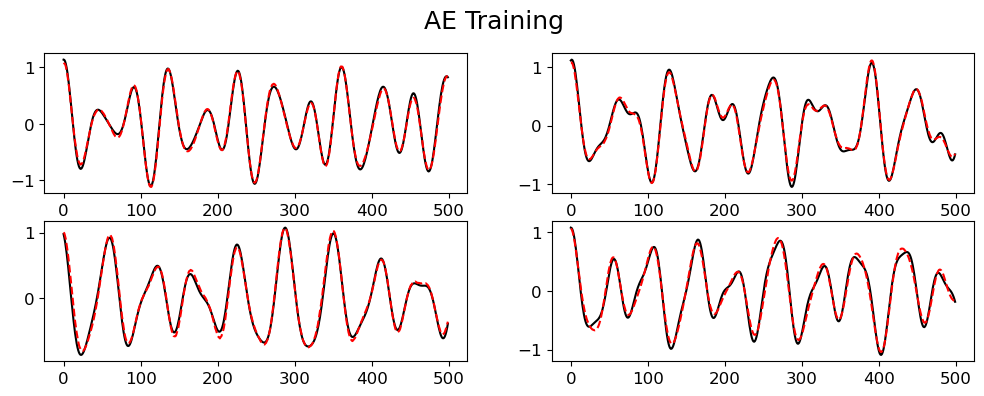

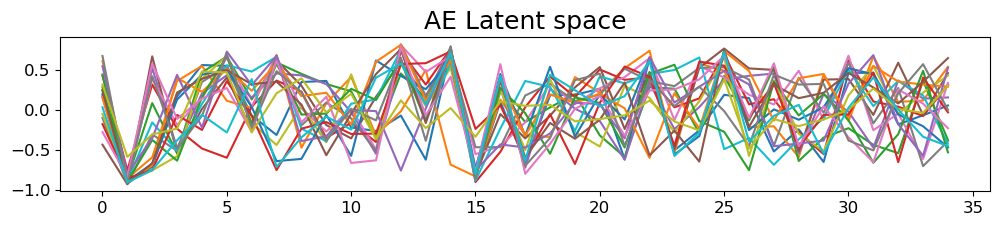

In [11]:
# Predict by manually piping encoder and decoder
latent = autoencoder.encode(x_train1)
x_train_ae = autoencoder.decode(latent)

# Visualization
n = 4
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs = axs.flatten()
plt.suptitle('AE Training', y=0.99)
for i in range(n):
    # display original
    axs[i].plot(x_train1[i].cpu().detach().numpy(), 'k')
    
    # display reconstruction
    axs[i].plot(x_train_ae[i].cpu().detach().numpy(), '--r')
    
plt.figure(figsize=(12, 2))
plt.plot(latent[:20].cpu().detach().numpy().T)
plt.title('AE Latent space');

## Reconstruction

First of all, we define the signal we wish to reconstruct (taken from the validation data) and we create the data.

We then apply the 3 different inversion algorithms and compare their solutions

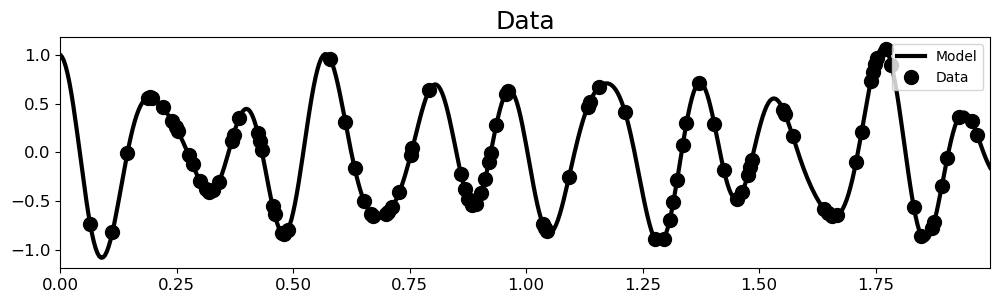

In [12]:
m = x_valid1[0].clone()
d = Rop * m.view(-1)

# Visualize data
fig = plt.figure(figsize=(12, 3))
plt.plot(t, m.cpu(), 'k', lw=3, label='Model')
plt.plot(t[iava], d.cpu(), '.k', ms=20, label='Data')
plt.legend(loc='upper right')
plt.xlim([t[0], t[-1]])
plt.title('Data');

### Spatially regularized inversion

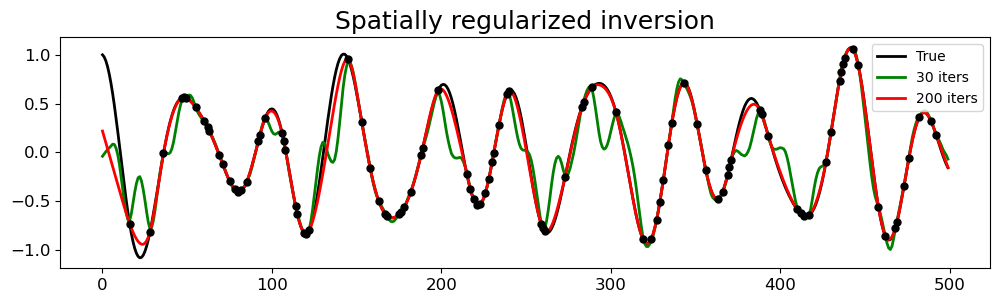

In [13]:
# Second derivative regularizer
D2op = pylops.SecondDerivative(nt, dims=None, dtype='float64')

# Invert and log each step (this could be done more efficiently using callbacks in new pylops)
resnormne = np.zeros(maxiter)
errnormne = np.zeros(maxiter)
for iiter in range(maxiter):
    mne = \
        pylops.optimization.leastsquares.NormalEquationsInversion(
        R1op, [D2op], d.cpu().detach().numpy(), epsI=epsI, epsRs=[epsR],
        **dict(maxiter=iiter+1))
    resnormne[iiter] = np.linalg.norm(d.cpu().detach().numpy() - R1op * mne)
    errnormne[iiter] = np.linalg.norm(m.cpu().detach().numpy() - mne)

# Invert with 200 iterations    
mne_long = pylops.optimization.leastsquares.NormalEquationsInversion(
    R1op, [D2op], d.cpu().detach().numpy(), epsI=epsI, epsRs=[epsR],
    **dict(maxiter=200))

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(m.cpu(), 'k', lw=2, label='True')
ax.plot(mne, 'g', lw=2, label=f'{maxiter} iters')
ax.plot(mne_long, 'r', lw=2,label='200 iters')
ax.plot(iava, d.cpu(), '.k', lw=2, ms=10)
ax.set_title('Spatially regularized inversion')
ax.legend();

### PCA preconditioned inversion

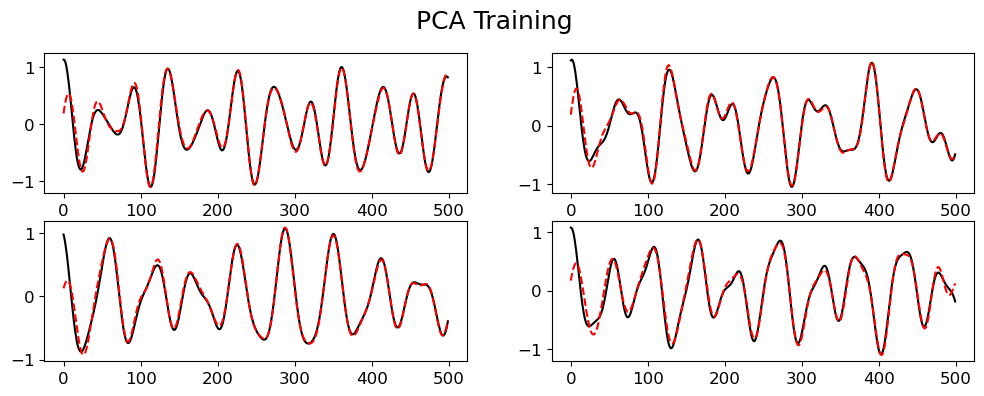

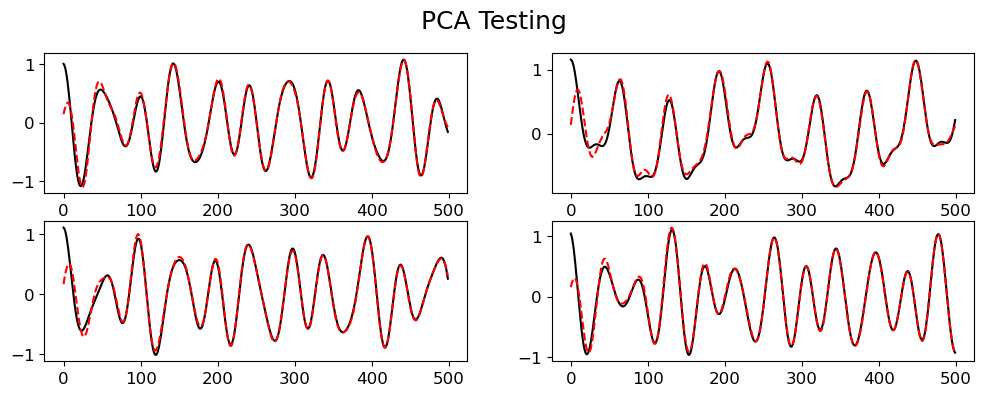

In [14]:
# PCA training
pca = PCA(n_components=nenc)
pca.fit(x_train1.cpu().detach().numpy())
pca.mean_ *= 0. # need to avoid adding/subtracting mean for dot-test to pass

x_train_pca = pca.inverse_transform(pca.transform(x_train1.cpu().detach().numpy()))
x_valid_pca = pca.inverse_transform(pca.transform(x_valid1.cpu().detach().numpy()))

# Visualization
n = 4
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
axs = axs.flatten()
plt.suptitle('PCA Training', y=0.99)
for i in range(n):
    # display original
    axs[i].plot(x_train1[i].cpu().detach().numpy(), 'k')
    
    # display reconstruction
    axs[i].plot(x_train_pca[i], '--r')
    
fig, axs = plt.subplots(2, 2, figsize=(12, 4))
plt.suptitle('PCA Testing', y=0.99)
axs = axs.flatten()
for i in range(n):
    # display original
    axs[i].plot(x_valid1[i].cpu().detach().numpy(), 'k')
    
    # display reconstruction
    axs[i].plot(x_valid_pca[i], '--r')

Dot test passed, v^H(Opu)=-3.704383374304387 - u^H(Op^Hv)=-3.7043833743043906


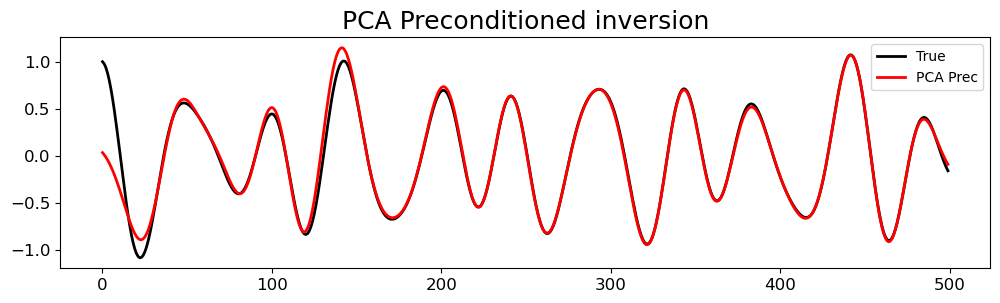

In [15]:
# PCA operator
PCAop = pylops.FunctionOperator(lambda x: pca.inverse_transform(x).ravel(), 
                                lambda x: pca.transform(x.reshape(-1, 1).reshape(1, -1)).ravel(), 
                                nt, nenc)
pylops.utils.dottest(PCAop, nt, nenc, raiseerror=False, verb=True)

#PCA prec inversion
resnormpca = np.zeros(maxiter)
errnormpca = np.zeros(maxiter)
for iiter in range(maxiter):
    mpca = \
        pylops.optimization.leastsquares.NormalEquationsInversion(
        R1op*PCAop, [], d.cpu().detach().numpy(), epsI=epsI,
        **dict(maxiter=iiter+1))
    mpca = PCAop * mpca
    resnormpca[iiter] = np.linalg.norm(d.cpu().detach().numpy() - R1op * mpca)
    errnormpca[iiter] = np.linalg.norm(m.cpu().detach().numpy() - mpca)  

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(m.cpu(), 'k', lw=2, label='True')
ax.plot(mpca, 'r', lw=2, label=f'PCA Prec')
ax.set_title('PCA Preconditioned inversion')
ax.legend();

### Deep preconditioned inversion

In [16]:
# Define function and gradient for scipy optimizer
def fun(x, yobs, network, Op, distance):
    x = torch.from_numpy(x.astype(np.float32)).to(device)
    y = Op(x)
    j = distance(y, yobs).cpu().detach().numpy()
    return float(j)

def grad(x, yobs, network, Op, distance):
    x = torch.tensor(x.astype(np.float32), requires_grad=True, device=device)
    y = Op(x)
    loss = distance(y, yobs)
    loss.backward(retain_graph=True)
    grad = x.grad.cpu().detach().numpy()
    return grad.astype(np.float64)

f = lambda x: fun(x, d, autoencoder, autoencoder.restricted_decode, criterion)
g = lambda x: grad(x, d, autoencoder, autoencoder.restricted_decode, criterion)

niter=30, nfeval=32


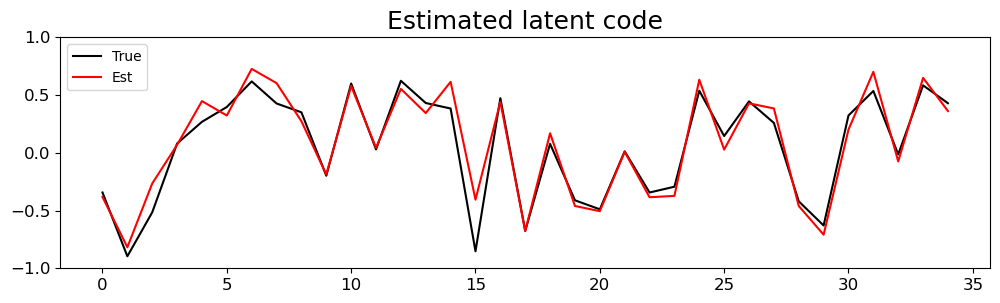

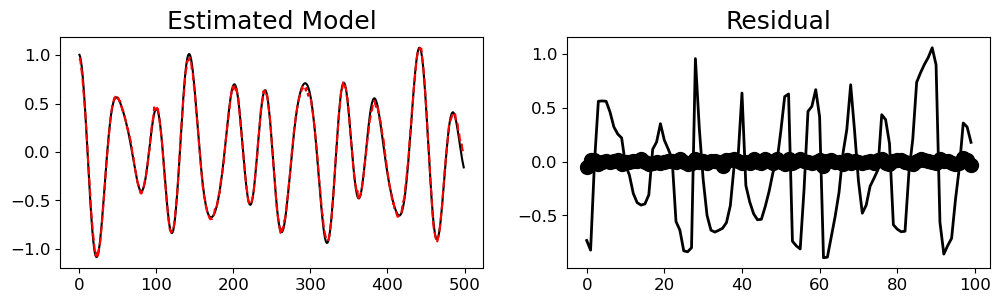

In [17]:
nfeval = 0
resnormae_sp = np.zeros(maxiter)
errnormae_sp = np.zeros(maxiter)

def callback(x, y, forward, prec, xtrue):
    global nfeval, resnorm_sp, errnorm_sp 
    res = y - forward(torch.from_numpy(x.astype(np.float32)).to(device)).cpu().detach().numpy()
    err = prec(torch.from_numpy(x.astype(np.float32).reshape(1, x.shape[0])).to(device)).cpu().detach().numpy().ravel() - xtrue.cpu().detach().numpy().ravel()
    resnormae_sp[nfeval] = np.linalg.norm(res)
    errnormae_sp[nfeval] = np.linalg.norm(err)
    nfeval += 1
    
nl = minimize(f, np.zeros(nenc, dtype=np.float32), jac=g, method='L-BFGS-B', 
              callback=lambda x: callback(x, d.cpu().detach().numpy(), 
                                          autoencoder.restricted_decode, autoencoder.decode, m),
              options=dict(maxiter=maxiter, disp=False))
print('niter=%d, nfeval=%d' %(nl.nit, nl.nfev))
pnl = nl.x
mnl = autoencoder.decode(torch.from_numpy(pnl.astype(np.float32)).to(device)).cpu().detach().numpy()
dnl = Rop * mnl

plt.figure(figsize=(12, 3))
plt.plot(autoencoder.encode(m).cpu().detach().numpy(), 'k', label='True')
plt.plot(pnl, 'r', label='Est')
plt.ylim(-1,1)
plt.legend()
plt.title('Estimated latent code')

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(m.cpu(), 'k', label='True')
axs[0].plot(mnl, '--r', label='Estimate')
axs[0].set_title('Estimated Model')
axs[1].plot(d.cpu().detach().numpy(), 'k', ms=20, lw=2)
axs[1].plot(d.cpu().detach().numpy()-dnl, '--.k', ms=20, lw=2)
axs[1].set_title('Residual');

## Comparison

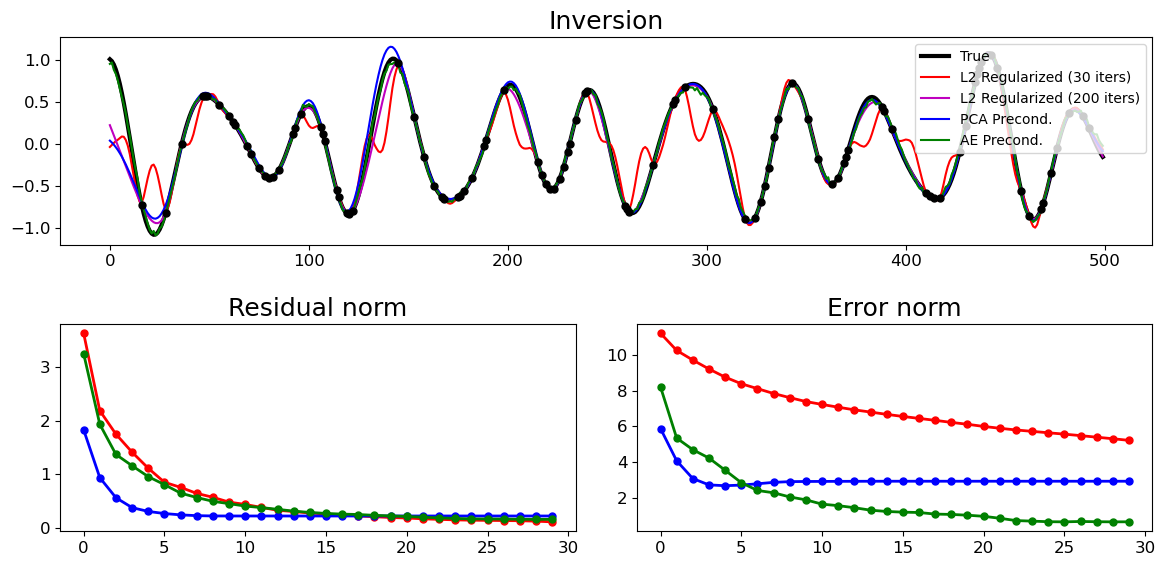

In [18]:
fig = plt.figure(figsize=(12, 6))
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 1), colspan=1)

ax0.plot(m.cpu(), 'k', lw=3, label='True')
ax0.plot(mne, 'r', label='L2 Regularized (30 iters)')
ax0.plot(mne_long, 'm', label='L2 Regularized (200 iters)')
ax0.plot(mpca, 'b', label='PCA Precond.')
ax0.plot(mnl, 'g', label='AE Precond.')
ax0.plot(iava, d.cpu(), '.k', ms=10)
ax0.set_title('Inversion')
ax0.legend(loc='upper right')
plt.tight_layout()

ax1.plot(resnormne, '.-r', lw=2, ms=10,)
ax1.plot(resnormpca, '.-b', lw=2, ms=10)
ax1.plot(resnormae_sp, '.-g', lw=2, ms=10)
ax1.set_title('Residual norm')

ax2.plot(errnormne, '.-r', lw=2, ms=10)
ax2.plot(errnormpca, '.-b', lw=2, ms=10)
ax2.plot(errnormae_sp, '.-g', lw=2, ms=10)
ax2.set_title('Error norm')
plt.tight_layout();